In [ ]:
# Instalar librerías necesarias
!pip install -Uqq kaggle opencv-python-headless geopandas shapely rasterio folium
!pip install -U tensorflow scikit-learn matplotlib

# Subir tu archivo kaggle.json
from google.colab import files
files.upload()  # ← Selecciona kaggle.json

# Configurar autenticación con Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descargar el dataset
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset
!unzip -q deepglobe-road-extraction-dataset.zip -d dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset
License(s): other
100% 3.79G/3.79G [00:46<00:00, 94.3MB/s]
100% 3.79G/3.79G [00:46<00:00, 87.6MB/s]


In [ ]:
import os, random, numpy as np
from glob import glob
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.metrics import Recall, Precision
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import (Input, Conv2D, BatchNormalization, MaxPool2D, Conv2DTranspose, Concatenate, LeakyReLU)
from keras.models import Model

H, W = 256, 256
BATCH_SIZE = 8
#EPOCHS = 30
EPOCHS = 3
DATA_PATH = 'dataset/train'
smooth = 1e-15

# Métricas
def iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def soft_dice_coef(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1.0 - soft_dice_coef(y_true, y_pred)

# Leer imágenes y máscaras
def read_image(path):
    img = Image.open(path).resize((W, H))
    return np.array(img, dtype=np.float32) / 255.0

def read_mask(path):
    mask = Image.open(path).convert('L').resize((W, H))
    x = np.array(mask, dtype=np.float32) / 255.0
    return np.expand_dims(x, axis=-1)

def tf_parse(x, y):
    def _parse(x, y):
        return read_image(x), read_mask(y)
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=BATCH_SIZE, repeat=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse).batch(batch).prefetch(tf.data.AUTOTUNE)
    if repeat: dataset = dataset.repeat()
    return dataset

# Cargar paths
images = sorted(glob(DATA_PATH + '/*sat.jpg'))
masks = sorted(glob(DATA_PATH + '/*mask.png'))
train_x, val_x, train_y, val_y = train_test_split(images, masks, test_size=0.2, random_state=42)

train_ds = tf_dataset(train_x, train_y, repeat=True)
val_ds = tf_dataset(val_x, val_y)

# Construir modelo
def conv_block(x, filters):
    for _ in range(2):
        x = Conv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

def encoder_block(x, f):
    c, p = conv_block(x, f), MaxPool2D((2,2))(x)
    return c, p

def decoder_block(x, skip, f):
    x = Conv2DTranspose(f, (2,2), strides=(2,2), padding='same')(x)
    x = Concatenate()([x, skip])
    return conv_block(x, f)

def build_unet(input_shape):
    i = Input(input_shape)
    c1, p1 = encoder_block(i, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)
    bn = conv_block(p4, 1024)
    d1 = decoder_block(bn, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)
    o = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)
    return Model(i, o)

model = build_unet((H, W, 3))
model.compile(optimizer=Adam(1e-4), loss=soft_dice_loss, metrics=[soft_dice_coef, iou, Recall(), Precision()])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (MaxPooling2D)      │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64, 3) │          0 │ max_pooling2d[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32, 3) │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16, 3) │          0 │ max_pooling2d_2[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │     28,672 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      4,096 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     14,336 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ leaky_re_lu_8[0]… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      4,096 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ leaky_re_lu_6[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ leaky_re_lu_9[0]

 Total params: 24,840,257 (94.76 MB)

 Trainable params: 24,828,481 (94.71 MB)

 Non-trainable params: 11,776 (46.00 KB)

Entrenar el modelo

In [ ]:
#steps_per_epoch = len(train_x) // BATCH_SIZE
#val_steps = len(val_x) // BATCH_SIZE

steps_per_epoch = (len(train_x) // BATCH_SIZE) // 8  # Reduce a la cuarta parte
val_steps = (len(val_x) // BATCH_SIZE) // 8

history = model.fit(train_ds,
                    validation_data=val_ds,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=val_steps,
                    epochs=EPOCHS)

# Guardar modelo
model.save("unet_roads.h5")

Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 4089s 53s/step - iou: 0.0836 - loss: 0.8676 - precision: 0.1180 - recall: 0.8067 - soft_dice_coef: 0.1324 - val_iou: 9.9619e-06 - val_loss: 0.9309 - val_precision: 0.0149 - val_recall: 1.0748e-05 - val_soft_dice_coef: 0.0691
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 4050s 53s/step - iou: 0.1126 - loss: 0.8263 - precision: 0.1680 - recall: 0.7327 - soft_dice_coef: 0.1737 - val_iou: 5.5750e-20 - val_loss: 0.9388 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_soft_dice_coef: 0.0612
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 4053s 53s/step - iou: 0.1146 - loss: 0.8213 - precision: 0.1705 - recall: 0.6959 - soft_dice_coef: 0.1787 - val_iou: 1.2364e-04 - val_loss: 0.9422 - val_precision: 0.0583 - val_recall: 1.1644e-04 - val_soft_dice_coef: 0.0578


In [ ]:
import cv2, geopandas as gpd, matplotlib.pyplot as plt
from shapely.geometry import LineString
from google.colab import files

# Subir imagen JPG o TIFF sin anotación
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Leer imagen
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img_resized = cv2.resize(img, (W, H))
img_input = np.expand_dims(img_resized / 255.0, axis=0)

# Cargar modelo y predecir
model = tf.keras.models.load_model("unet_roads.h5", compile=False)
pred = model.predict(img_input)[0]
mask_bin = (pred > 0.5).astype(np.uint8).squeeze()

# Contornos y líneas
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
lines = [LineString(cnt.squeeze()) for cnt in contours if len(cnt.squeeze()) >= 2]
gdf = gpd.GeoDataFrame(geometry=lines, crs='EPSG:4326')  # Puedes cambiar CRS si tienes coordenadas reales

# Guardar como GeoJSON
gdf.to_file("camino.geojson", driver="GeoJSON")
files.download("camino.geojson")

Saving Captura de pantalla 2025-06-18 233624.png to Captura de pantalla 2025-06-18 233624.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

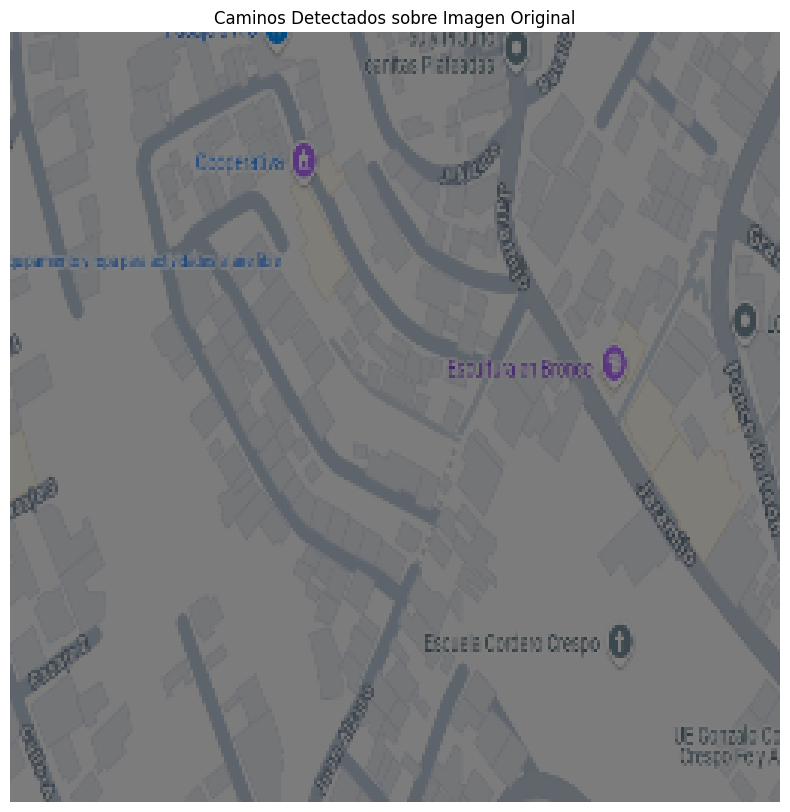

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.imshow(mask_bin, cmap='gray', alpha=0.5)
plt.title("Caminos Detectados sobre Imagen Original")
plt.axis('off')
plt.show()

# Nuevo código

In [11]:
from skimage.morphology import skeletonize
from skimage.util import invert

# Convertir la máscara binaria a esqueleto (1 px de grosor)
binary = (mask_bin > 0).astype(np.uint8)
skeleton = skeletonize(binary).astype(np.uint8)

In [12]:
import cv2
from shapely.geometry import LineString
import geopandas as gpd

# Detectar contornos en el esqueleto
contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Convertir cada contorno en un LineString si tiene más de 1 punto
lines = [LineString(cnt.squeeze()) for cnt in contours if len(cnt.squeeze()) >= 2]

# Crear GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=lines, crs='EPSG:4326')  # Cambia el CRS si tienes coordenadas reales

In [17]:
# Guardar en archivo GeoJSON
gdf.to_file("caminotrazo.geojson", driver="GeoJSON")

# Descargar desde Colab
from google.colab import files
files.download("camino.geojson")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

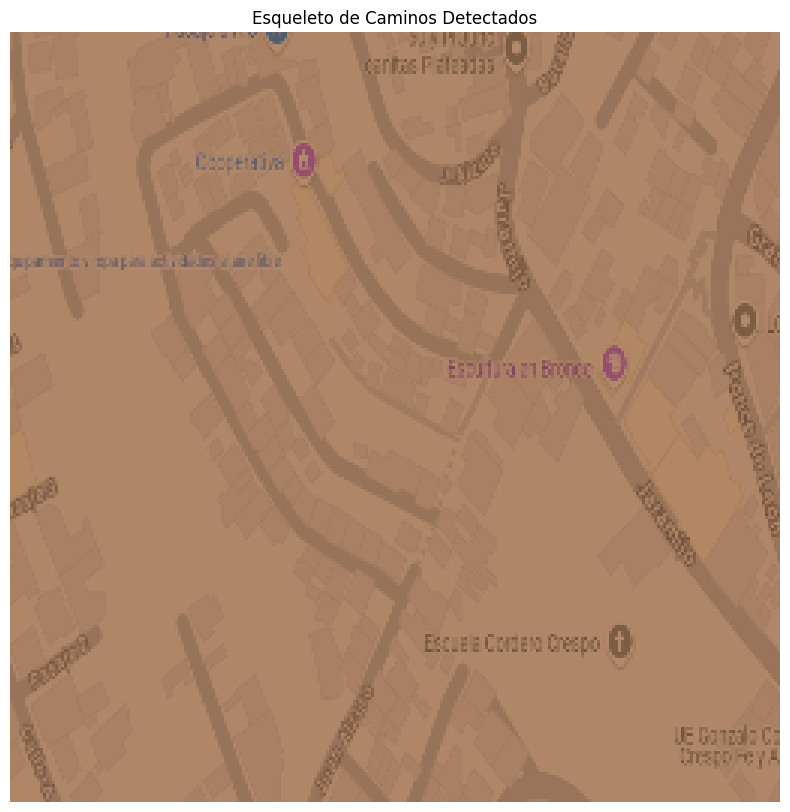

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.imshow(skeleton, cmap='PuOr', alpha=0.6)
plt.title("Esqueleto de Caminos Detectados")
plt.axis('off')
plt.show()

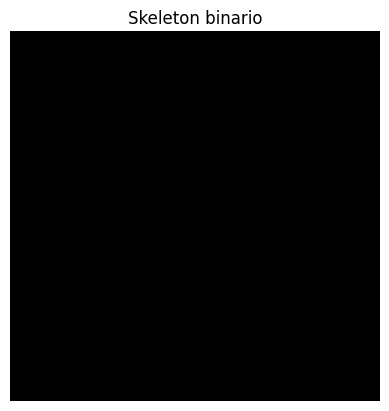

In [23]:
import matplotlib.pyplot as plt

plt.imshow(skeleton, cmap='gray')
plt.title("Skeleton binario")
plt.axis('off')
plt.show()

In [24]:
import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from shapely.geometry import LineString
from shapely.affinity import affine_transform
from skimage.morphology import skeletonize
import tensorflow as tf

def detectar_caminos_con_geojson(
    imagen_path,
    modelo_path,
    coord_min=(-78.51, -0.20),  # Inferior izquierda (lon, lat)
    coord_max=(-78.49, -0.18),  # Superior derecha (lon, lat)
    salida_geojson="camino.geojson",
    visualizar=True
):
    # Dimensiones
    H, W = 256, 256

    # Leer imagen y redimensionar
    img_orig = cv2.imread(imagen_path, cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img_orig, (W, H))
    img_input = np.expand_dims(img_resized / 255.0, axis=0)

    # Cargar modelo y predecir
    modelo = tf.keras.models.load_model(modelo_path, compile=False)
    pred = modelo.predict(img_input)[0]
    mask_bin = (pred.squeeze() > 0.5).astype(np.uint8)

    # Skeletonize
    skeleton = skeletonize(mask_bin).astype(np.uint8)

    # Contornos del esqueleto → LineStrings
    contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    lines = [LineString(cnt.squeeze()) for cnt in contours if len(cnt.squeeze()) >= 2]

    # Transformación de píxeles a lat/lon
    minx, miny = coord_min
    maxx, maxy = coord_max
    scale_x = (maxx - minx) / W
    scale_y = (maxy - miny) / H

    def pixel_to_geo(line):
        return affine_transform(line, [scale_x, 0, 0, -scale_y, minx, maxy])

    lines_geo = [pixel_to_geo(line) for line in lines]
    gdf = gpd.GeoDataFrame(geometry=lines_geo, crs="EPSG:4326")

    # Exportar
    gdf.to_file(salida_geojson, driver="GeoJSON")

    # Visualizar
    if visualizar:
        plt.figure(figsize=(10,10))
        plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
        plt.imshow(skeleton, cmap='gray', alpha=0.6)
        plt.title("Caminos detectados (esqueleto central)")
        plt.axis('off')
        plt.show()

    print(f"GeoJSON exportado a: {salida_geojson}")
    return gdf

Saving Captura de pantalla 2025-06-18 233624.png to Captura de pantalla 2025-06-18 233624 (4).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step


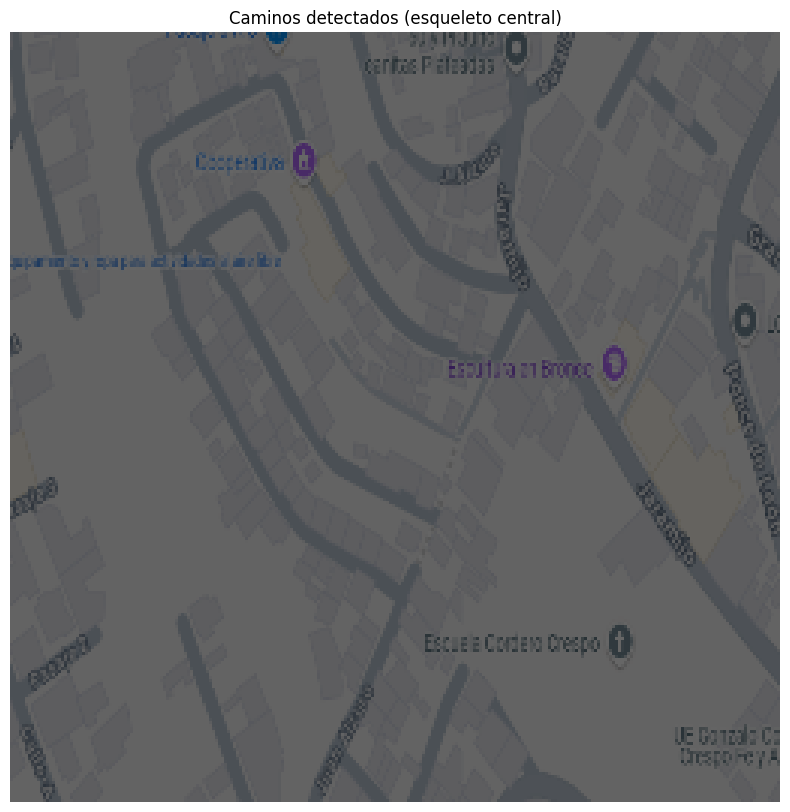

GeoJSON exportado a: camino.geojson


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# Subir imagen nueva y modelo entrenado
from google.colab import files
uploaded = files.upload()

# Por ejemplo:
# imagen = "mi_imagen_sat.jpg"
# modelo = "unet_roads.h5"

gdf = detectar_caminos_con_geojson(
    imagen_path="Captura de pantalla 2025-06-18 233624 (1).png",
    modelo_path="unet_roads.h5",
    coord_min=(-78.51, -0.20),
    coord_max=(-78.49, -0.18),
    salida_geojson="camino.geojson"
)

# Descargar el archivo
files.download("camino.geojson")

In [26]:
print("Máxima intensidad en la predicción:", pred.max())

Máxima intensidad en la predicción: 0.48969296
